上一篇Qlib的分享中，我们主要介绍了如何将外部数据导入qlib中，转换为qlib的数据格式。我们还需要补充一点的是，上次我们只导入了日度的价格数据。但实际上任何在研究中需要使用的数据（当然必须是股票某个属性的数据）都可以导入其中，你可以选择构建一张超宽的表使用dump_all一次性导入，也可以分批使用dump_fix导入。当数据加载后，我们就可以利用这些数据进行研究。

In [10]:
import qlib
from qlib.constant import REG_CN
data_uri = '/Users/lusong/.qlib/qlib_data/cn_data_wind/'

In [11]:
qlib.init(provider_uri=data_uri, region=REG_CN)

[32168:MainThread](2022-05-01 00:07:36,017) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[32168:MainThread](2022-05-01 00:07:36,019) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[32168:MainThread](2022-05-01 00:07:36,020) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/lusong/.qlib/qlib_data/cn_data_wind')}


Qlib中关于数据主要有以下三个模块：
* Data Loader: 从数据源加载数据，数据源可以是已经转换为qlib内置格式的数据（如上面data_uri里面的数据），也可以是其他外部数据；
* Data Handler: 对数据进行预处理，比如常见的缺失值、标准化等；
* Dataset: 为模型的训练准备数据，类似Pytorch中的Dataset。

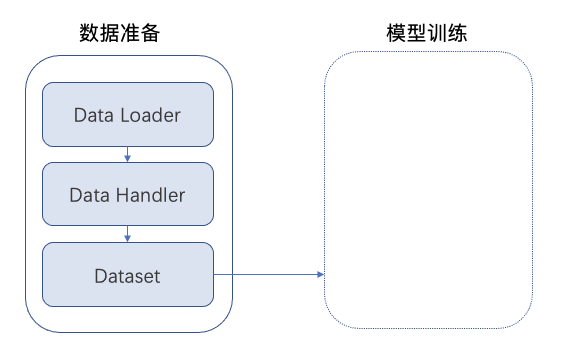

# Data Loder

Data Loader用于加载数据，Qlib中主要有两类Data Loader：
* QlibDataLoader：从已转换好的内置数据源中加载数据；
* StaticDataLoader：从外部数据源加载数据


## QlibDataLoader
使用QlibDataLoader加载数据需要两个步骤：
* 实例化，主要是通过config参数配置需要加载的数据，可以是原始数据，也可以是用算法表达式计算的数据
* 实例化之后，使用load函数获取数据。

我们看以下案例

In [20]:
# 导入QlibDataLoader
from qlib.data.dataset.loader import QlibDataLoader

In [21]:
# 加载原始特征，比如收盘价、最高价
qdl = QlibDataLoader(config=(['$close', '$high'],['close', 'high'])) 
qdl.load(instruments=['SH600519'], start_time='20190101', end_time='20191231') # 可以通过freq参数设置周期，默认freq='day'

,,close,high
datetime,instrument,,
2019-01-02,SH600519,4319.709961,4413.609863
2019-01-03,SH600519,4254.950195,4339.040039
2019-01-04,SH600519,4341.490234,4382.379883
2019-01-07,SH600519,4366.660156,4413.609863
2019-01-08,SH600519,4361.609863,4413.609863
...,...,...,...
2019-12-25,SH600519,8297.070312,8365.129883
2019-12-26,SH600519,8307.309570,8357.669922
2019-12-27,SH600519,8511.500000,8577.370117


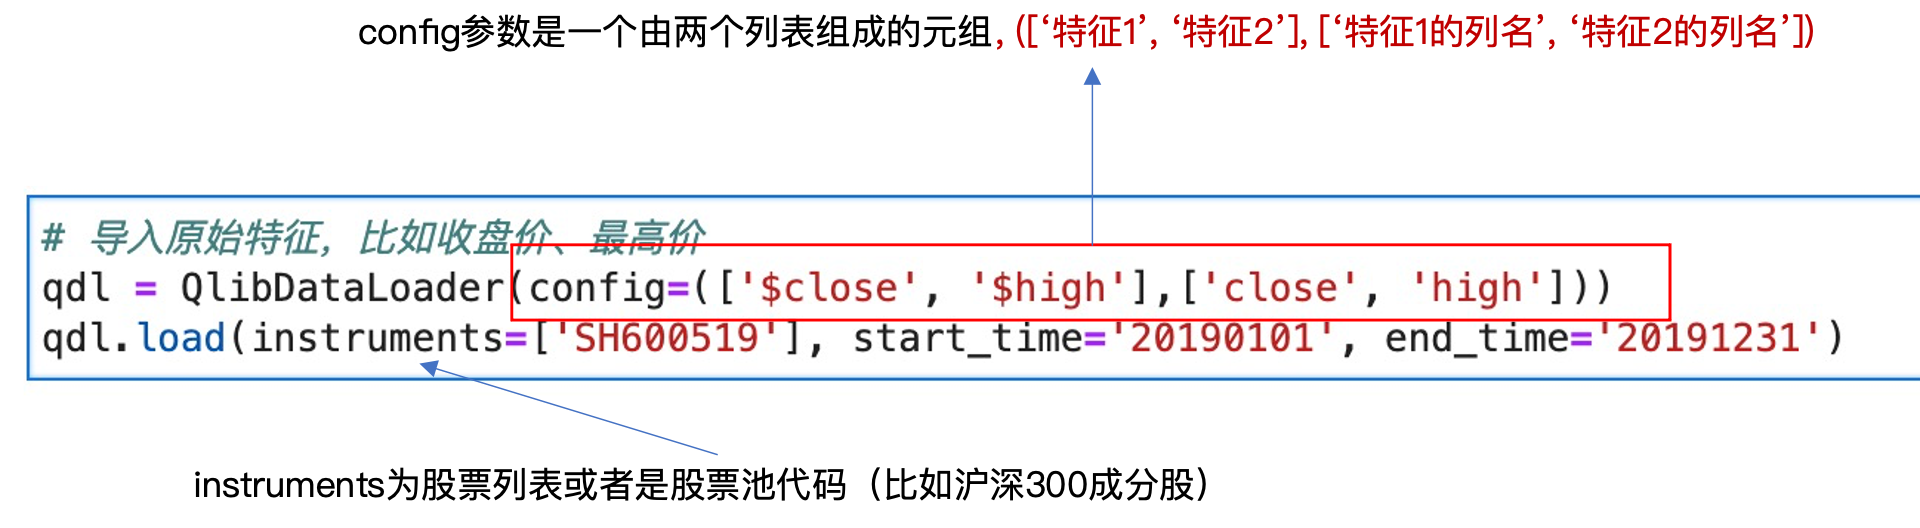

在以上的案例中，有以下几个注意点：
* config参数用来配置需要加载的特征，对于qlib内置数据中原有的特征需要使用"$"符号进行引用；
* instruments可以为股票代码的列表，也可以是某个股票池代码，前提是该股票池成分股文件存在于qlib数据文件夹"instruments"中。

除了直接加载原始特征，有时我们需要对不同的原始特征做一些运算生成新的特征，比如我们想计算收盘价的均线。这时我们可以使用qlib的算式表达式功能，直接在加载时进行计算，具体请看下面案例。

In [24]:
# 这次我们加载沪深300成分股的10日和30日收盘价指数加权均价
market = 'sh000300' # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
close_ma = ['EMA($close, 10)', 'EMA($close, 30)'] # EMA($close, 10)表示计算close的10日指数加权均线
ma_names = ['EMA10', 'EMA30']
qdl_ma = QlibDataLoader(config=(close_ma, ma_names)) 
qdl_ma.load(instruments=market, start_time='20210101', end_time='20210110')

EMA10       EMA30
datetime   instrument                        
2021-01-04 SH600000    128.776688  130.428864
           SH600004     35.711178   36.639740
           SH600009    227.689270  231.307571
           SH600010      9.757089    9.815779
           SH600011     21.803612   22.311543
...                           ...         ...
2021-01-08 SZ300498     38.268608   38.167015
           SZ300529    146.323364  141.267807
           SZ300601    252.086090  247.119064
           SZ300628    906.532104  892.788696
           SZ300676    134.093430  132.403580

[1500 rows x 2 columns]

qlib把类似“EMA”称为算子（operator），qlib中全部支持的算子可以在以下源码中找到：/qlib/data/ops.py

有时我们需要对计算的数据进行分组，最常用的是分为特征组“feature”和“label”组，此时我们可以传入dict格式的参数至config中，具体看下面实例：

In [117]:
market = 'sh000300' # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
close_ma = ['EMA($close, 10)', 'EMA($close, 30)'] # EMA($close, 10)表示计算close的10日指数加权均线
ma_names = ['EMA10', 'EMA30']
ret = ["Ref($close, -1)/$close-1"] # 下一日收益率, Ref($close, -1)表示下一日收盘价
ret_name = ['next_ret']
qdl_ma_gp = QlibDataLoader(config={'feature':(close_ma, ma_names), 'label': (ret, ret_name)}) 
qdl_ma_gp.load(instruments=market, start_time='20210101', end_time='20210110')

feature                 label
                            EMA10       EMA30  next_ret
datetime   instrument                                  
2021-01-04 SH600000    128.776688  130.428864 -0.001001
           SH600004     35.711178   36.639740 -0.016393
           SH600009    227.689270  231.307571 -0.002437
           SH600010      9.757089    9.815779 -0.008138
           SH600011     21.803612   22.311543 -0.022326
...                           ...         ...       ...
2021-01-08 SZ300498     38.268608   38.167015 -0.039302
           SZ300529    146.323364  141.267807 -0.047604
           SZ300601    252.086090  247.119064 -0.062272
           SZ300628    906.532104  892.788696 -0.009128
           SZ300676    134.093430  132.403580  0.053332

[1500 rows x 3 columns]

### QlibDataLoader其他参数: filter_pipe

在加载数据的过程中，我们不仅可以使用算子表达式进行特征计算，还可以使用“filter_pipe”参数进行相关过滤。比如我们想要加载沪深300中每一天10日均线大于30日均线的股票并返回它们的均线数据，该怎么实现呢？

In [33]:
from qlib.data.filter import ExpressionDFilter
# QlibDataLoader其他参数: filter_pipe
market = 'sh000300' # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
close_ma = ['EMA($close, 10)', 'EMA($close, 30)'] # EMA($close, 10)表示计算close的10日指数加权均线
ma_names = ['EMA10', 'EMA30']

# 使用表达式定义过滤规则
filter_rule = ExpressionDFilter(rule_expression='EMA($close, 10)>EMA($close, 30)')

# 导出数据
qdl_fil = QlibDataLoader(config=(close_ma, ma_names), filter_pipe=[filter_rule,]) 
qdl_fil.load(instruments=market, start_time='20210101', end_time='20210110')

EMA10        EMA30
datetime   instrument                          
2021-01-04 SH600018       6.580720     6.537729
           SH600025       4.922013     4.930805
           SH600031    1637.023804  1573.120483
           SH600111     252.989182   250.658783
           SH600161     547.657776   540.620544
...                            ...          ...
2021-01-08 SZ300498      38.268608    38.167015
           SZ300529     146.323364   141.267807
           SZ300601     252.086090   247.119064
           SZ300628     906.532104   892.788696
           SZ300676     134.093430   132.403580

[744 rows x 2 columns]

## StaticDataLoader
QlibDataLoader用于加载已经转换为qlib格式的数据。如果直接从外部文件中读取数据，可以使用StaticDataLoader。

In [35]:
# 准备pickle数据文件
qdl = QlibDataLoader(config=(['$open', '$high', '$low', '$close'],['open', 'high', 'low', 'close']))
df = qdl.load(instruments='sh000300', start_time='20210101', end_time='20211231') # 可以通过freq参数设置周期，默认freq='day'
df.to_pickle('./sh000300.pkl')

In [45]:
# 使用StaticDataLoader导入数据
from qlib.data.dataset.loader import StaticDataLoader

# 实例化StaticDataLoader，主要是config函数，这里直接传入数据文件的路径
sdl_pkl = StaticDataLoader(config='./sh000300.pkl')
sdl_pkl.load() # 默认返回全部数据

open         high          low        close
datetime   instrument                                                    
2021-01-04 SH600000     129.229996   130.440002   128.029999   129.899994
           SH600004      36.759998    36.939999    36.049999    36.599998
           SH600009     232.479996   241.910004   230.860001   237.979996
           SH600010       9.750000     9.830000     9.670000     9.830000
           SH600011      21.500000    21.690001    21.209999    21.500000
...                            ...          ...          ...          ...
2021-12-31 SZ300782    1091.280029  1093.890015  1022.809998  1064.569946
           SZ300866     106.610001   107.459999   101.279999   102.989998
           SZ300888      82.940002    84.070000    82.379997    83.660004
           SZ300896     980.080017   990.659973   966.539978   969.520020
           SZ300999      62.689999    63.290001    62.400002    63.020000

[72900 rows x 4 columns]

In [46]:
# 也可以传入instruments和起止时间
sdl_pkl.load(instruments=['SH600000','SH600010'], start_time='2021-10-01', end_time='2021-10-15') 

open        high         low       close
datetime   instrument                                                
2021-10-08 SH600000    127.449997  128.850006  127.160004  127.870003
           SH600010     27.080000   27.250000   25.330000   25.660000
2021-10-11 SH600000    128.429993  130.259995  128.149994  128.850006
           SH600010     25.330000   25.660000   24.000000   25.160000
2021-10-12 SH600000    128.429993  129.419998  128.009995  128.710007
           SH600010     24.910000   25.410000   23.410000   23.910000
2021-10-13 SH600000    128.710007  128.850006  127.449997  127.730003
           SH600010     23.750000   24.750000   23.410000   24.250000
2021-10-14 SH600000    127.730003  128.009995  127.019997  127.300003
           SH600010     23.910000   24.660000   23.500000   24.160000
2021-10-15 SH600000    127.449997  128.289993  127.019997  127.730003
           SH600010     24.330000   24.500000   23.910000   24.250000

### 如何读取csv文件
以上我们读取的是pickle文件，如果是csv文件是否可以呢？

In [48]:
# 准备csv文件
df.to_csv('./sh000300.pkl')
sdl_csv = StaticDataLoader(config='./sh000300.csv')
sdl_csv.load() # 默认返回全部数据

UnpicklingError: could not find MARK

报错了，分析源码可以看出，当config是路径时，只支持pickle文件。但是当config是字典格式时{‘feature_group’: 'path'}可以支持csv\pickle\h5三种文件格式，（不知道作者出于什么考虑）。我们可以选择修改源码，或者直接使用dict格式的config参数，如下：

In [51]:
sdl_csv = StaticDataLoader(config={'feature': './sh000300.csv'})
sdl_csv.load()['feature'] # 默认返回全部数据

open     high      low    close
datetime   instrument                                    
2021-01-04 SH600000     129.23   130.44   128.03   129.90
           SH600004      36.76    36.94    36.05    36.60
           SH600009     232.48   241.91   230.86   237.98
           SH600010       9.75     9.83     9.67     9.83
           SH600011      21.50    21.69    21.21    21.50
...                        ...      ...      ...      ...
2021-12-31 SZ300782    1091.28  1093.89  1022.81  1064.57
           SZ300866     106.61   107.46   101.28   102.99
           SZ300888      82.94    84.07    82.38    83.66
           SZ300896     980.08   990.66   966.54   969.52
           SZ300999      62.69    63.29    62.40    63.02

[72900 rows x 4 columns]

当然以上是通过文件读取，如果数据已经以dataframe的形式存在内存里，我们可以直接构建StaticDataLoader：

In [52]:
sdl_df = StaticDataLoader(config=df)
sdl_df.load() # 默认返回全部数据

open         high          low        close
datetime   instrument                                                    
2021-01-04 SH600000     129.229996   130.440002   128.029999   129.899994
           SH600004      36.759998    36.939999    36.049999    36.599998
           SH600009     232.479996   241.910004   230.860001   237.979996
           SH600010       9.750000     9.830000     9.670000     9.830000
           SH600011      21.500000    21.690001    21.209999    21.500000
...                            ...          ...          ...          ...
2021-12-31 SZ300782    1091.280029  1093.890015  1022.809998  1064.569946
           SZ300866     106.610001   107.459999   101.279999   102.989998
           SZ300888      82.940002    84.070000    82.379997    83.660004
           SZ300896     980.080017   990.659973   966.539978   969.520020
           SZ300999      62.689999    63.290001    62.400002    63.020000

[72900 rows x 4 columns]

# Data Handler
通过Data Loader加载特征后，模型训练前需要对特征数据进行一些预处理，比如缺失值、标准化等处理。这是Data Handler主要任务。我们先看一个案例：

In [92]:
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import CSZScoreNorm, DropnaProcessor

qdl = QlibDataLoader(config=(['$close/Ref($close, 1)-1'],['Return']))
df = qdl.load(instruments='sh000300', start_time='20210101', end_time='20210430') 

In [112]:
# 是否有空值
df.isna().sum()

Return    45
dtype: int64

array([[<AxesSubplot:title={'center':'Return'}>]], dtype=object)

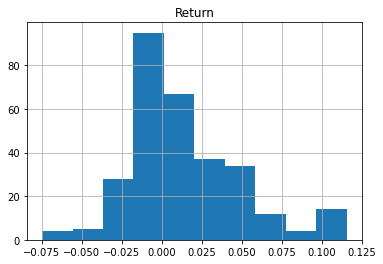

In [111]:
# 原始数据分布
df.xs('2021-01-05').hist()

In [102]:
# 实例化DataHandler
dh = DataHandlerLP(instruments='sh000300', start_time='20210101', end_time='20210120',
             learn_processors=[DropnaProcessor(), CSZScoreNorm()],
             data_loader=qdl)

[32168:MainThread](2022-05-01 16:11:37,168) INFO - qlib.timer - [log.py:113] - Time cost: 5.556s | Loading data Done
[32168:MainThread](2022-05-01 16:11:37,172) INFO - qlib.timer - [log.py:113] - Time cost: 0.002s | DropnaProcessor Done
[32168:MainThread](2022-05-01 16:11:37,197) INFO - qlib.timer - [log.py:113] - Time cost: 0.024s | CSZScoreNorm Done
[32168:MainThread](2022-05-01 16:11:37,198) INFO - qlib.timer - [log.py:113] - Time cost: 0.028s | fit & process data Done
[32168:MainThread](2022-05-01 16:11:37,198) INFO - qlib.timer - [log.py:113] - Time cost: 5.587s | Init data Done


In [105]:
df_hdl = dh.fetch(data_key=DataHandlerLP.DK_L) # 获取处理后的数据，处理过程为先去空值，再截面标准化。

In [106]:
# 查看是否还存在空值
df_hdl.isna().sum()

Return    0
dtype: int64

array([[<AxesSubplot:title={'center':'Return'}>]], dtype=object)

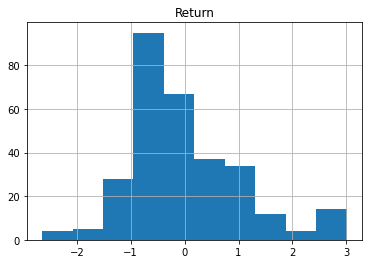

In [108]:
# CSZScoreNorm截面标准化处理后的数据分布
df_hdl.xs('2021-01-05').hist()

从以上的例子可以看出，实例化Data Handler需要以下几个参数：

* 基本信息，如instruments，start_time，end_time
* infer_processors，数据处理器，列表格式。由Dataloader加载的数据会依次经过该列表中的processor进行处理。（后面会详细介绍）
* data_loader，数据加载器实例。

Data Handler实例化之后，通过fetch方法获取处理后的数据，这里的参数DataHandlerLP.DK_L会在Learn Processor VS Infer Processor详细介绍。

## Processor

Data Handler中对于数据的预处理的具体工作是由Processor完成的，Qlib中支持以下Processors，这些Processor都继承自Processor类。我们也可以通过该继承实现自定义的processor。

* `DropnaProcessor`: processor that drops N/A features.
* `DropnaLabel`: processor that drops N/A labels.
* `TanhProcess`: processor that uses tanh to process noise data.
* `ProcessInf`: processor that handles infinity values, it will be replaces by the mean of the column.
* `Fillna`: processor that handles N/A values, which will fill the N/A value by 0 or other given number.
* `MinMaxNorm`: processor that applies min-max normalization.
* `ZscoreNorm`: processor that applies z-score normalization.
* `RobustZScoreNorm`: processor that applies robust z-score normalization.
* `CSZScoreNorm`: processor that applies cross sectional z-score normalization.
* `CSRankNorm`: processor that applies cross sectional rank normalization.
* `CSZFillna`: processor that fills N/A values in a cross sectional way by the mean of the column.



我们以上面使用的DropnaProcessor和CSZScoreNorm介绍processor的处理逻辑，首先看一下DropnaProcessor和CSZScoreNorm的源码：
```
class DropnaProcessor(Processor):
    def __init__(self, fields_group=None):
        self.fields_group = fields_group

    def __call__(self, df):
        return df.dropna(subset=get_group_columns(df, self.fields_group))

    def readonly(self):
        return True

class CSZScoreNorm(Processor):
    """Cross Sectional ZScore Normalization"""

    def __init__(self, fields_group=None, method="zscore"):
        self.fields_group = fields_group
        if method == "zscore":
            self.zscore_func = zscore
        elif method == "robust":
            self.zscore_func = robust_zscore
        else:
            raise NotImplementedError(f"This type of input is not supported")

    def __call__(self, df):
        # try not modify original dataframe
        if not isinstance(self.fields_group, list):
            self.fields_group = [self.fields_group]
        for g in self.fields_group:
            cols = get_group_columns(df, g)
            df[cols] = df[cols].groupby("datetime").apply(self.zscore_func)
        return df
```

可以看出，Processor中均实现了__call__方法，通过把原始数据df传入__call__完成数据的预处理。我们单独实例化Fillna和Zscorenorm进行数据处理，验证一下结果是否同上面Data Handler返回的一致。

In [113]:
# copy df数据
df_test = df.copy()

# 实例化Processor
dropna_processor = DropnaProcessor()
czs_processor = CSZScoreNorm()

# 处理数据
for process_func in [dropna_processor, czs_processor]:
    df_test = process_func(df_test)

In [114]:
# 查看是否还有空数据
df_test.isna().sum()

Return    0
dtype: int64

array([[<AxesSubplot:title={'center':'Return'}>]], dtype=object)

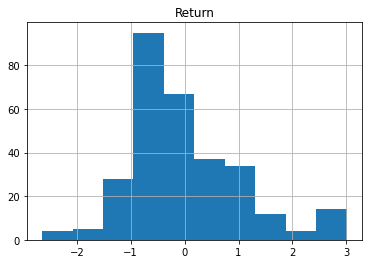

In [116]:
# CSZScoreNorm截面标准化处理后的数据分布, 和上面的结果一致。
df_test.xs('2021-01-05').hist()

## Learn Processor VS Infer Processor

在上面的实例中，我们设置的Data Handler的参数learn_processors对数据进行预处理。查看源码可以发现，Data Handler关于数据处理的参数有以下三个：
* infer_processors：通过fit时间段的数据学习相关参数，在非fit时间段进行数据处理。
* learn_processors：不需要fit直接进行数据处理
* shared_processors：共享的处理器。

Data Handler会在处理过程中，保存原始数据和处理后的数据，在fetch数据时，会根据参数data_key返回不同的数据：
* data_key = DatahandlerLP.DK_I, 返回_infer_df
* data_key = DatahandlerLP.DK_L, 返回_learn_df
* data_key = DatahandlerLP.DK_R, 返回原始数据（未处理过）

infer_processors、learn_processors及shared_processors配合process_type参数，可以改变数据预处理的顺序：

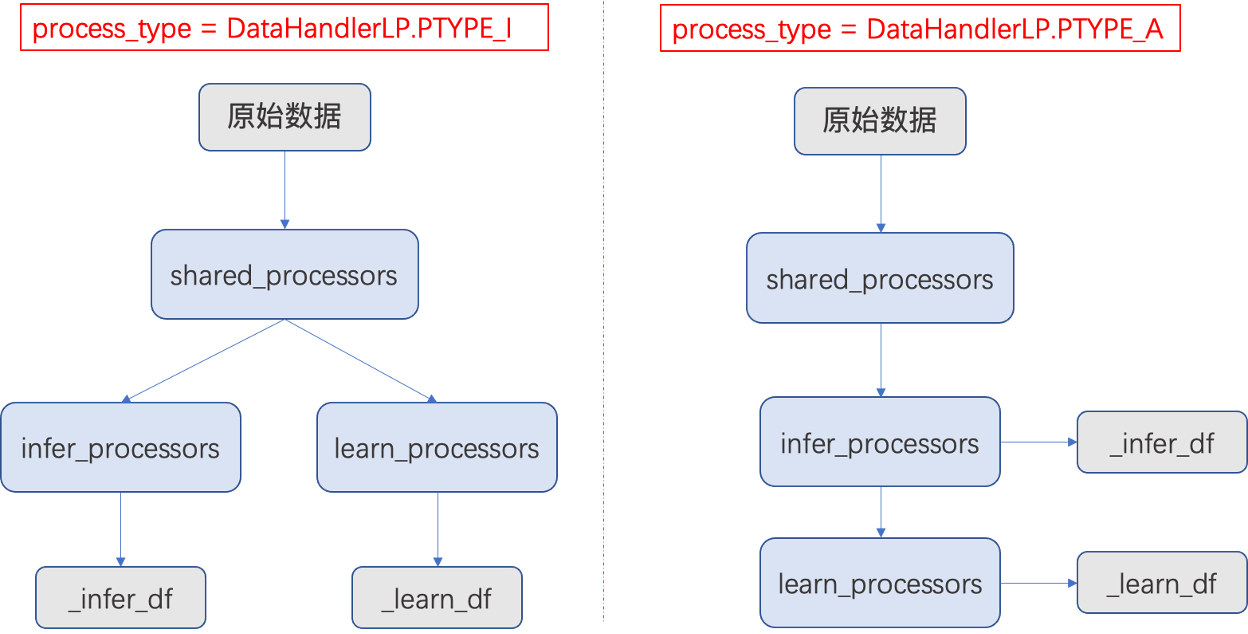

infer_processors和learn_processors最大的区别是infer_processors中processor会根据历史数据学习，然后在讲学习到的知识应用的未来数据的处理中。这类processor都有fit的方法，qlib内置的processor中如ZScoreNorm就是一个infer_processor，我们看一下源码：

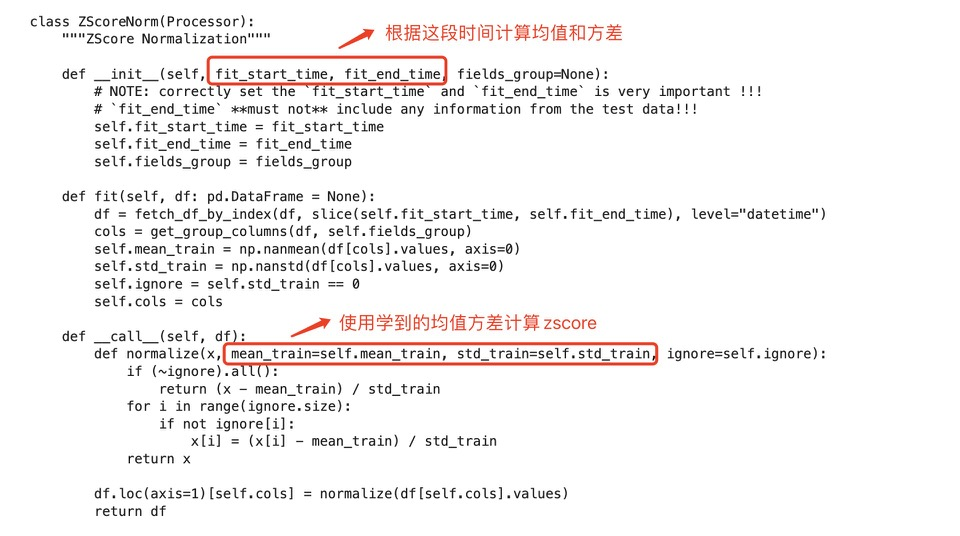

接下来，我们通过一个详细的实例梳理以上的知识点。

In [119]:
# 分别定义shared_processors, learn_processors, infer_processors
shared_processors = [DropnaProcessor()]
learn_processors = [CSZScoreNorm()]
infer_processors = [ZScoreNorm(fit_start_time='20210101', fit_end_time='20210110')]


dh_pr_test = DataHandlerLP(instruments='sh000300', 
                           start_time='20210101', 
                           end_time='20210120',
                           process_type=DataHandlerLP.PTYPE_I, 
                           learn_processors=learn_processors,
                           shared_processors=shared_processors,
                           infer_processors=infer_processors,
                           data_loader=qdl)

[32168:MainThread](2022-05-01 17:33:56,998) INFO - qlib.timer - [log.py:113] - Time cost: 5.217s | Loading data Done
[32168:MainThread](2022-05-01 17:33:57,002) INFO - qlib.timer - [log.py:113] - Time cost: 0.002s | DropnaProcessor Done
[32168:MainThread](2022-05-01 17:33:57,008) INFO - qlib.timer - [log.py:113] - Time cost: 0.005s | ZScoreNorm Done
[32168:MainThread](2022-05-01 17:33:57,031) INFO - qlib.timer - [log.py:113] - Time cost: 0.021s | CSZScoreNorm Done
[32168:MainThread](2022-05-01 17:33:57,032) INFO - qlib.timer - [log.py:113] - Time cost: 0.032s | fit & process data Done
[32168:MainThread](2022-05-01 17:33:57,033) INFO - qlib.timer - [log.py:113] - Time cost: 5.253s | Init data Done


按照以上设定，_infer_df应该是去空值，且在时序上标准化处理了；_learn_df应该是去空值，且在截面上标准化处理了，我们验证一下：

In [120]:
# 原始数据
_raw_df = dh_pr_test.fetch(data_key=DataHandlerLP.DK_R)

# 处理后的数据
_infer_df = dh_pr_test.fetch(data_key=DataHandlerLP.DK_I)
_learn_df = dh_pr_test.fetch(data_key=DataHandlerLP.DK_L)

由于shared_processors为去空值，可以看出_infer_df和_learn_df中的空值都没有了

In [121]:
_infer_df.isna().sum()

Return    0
dtype: int64

In [122]:
_learn_df.isna().sum()

Return    0
dtype: int64

由于infer_processors和learn_processors不一样，我们可以看到处理后的数据也不一样

In [128]:
_learn_df.xs('20210105').head()

,Return
instrument,
SH600000,-0.454992
SH600004,-0.911927
SH600009,-0.497634
SH600010,-0.666874
SH600011,-1.088024


In [127]:
_infer_df.xs('20210105').head()

,Return
instrument,
SH600000,-0.294122
SH600004,-0.770344
SH600009,-0.338563
SH600010,-0.514948
SH600011,-0.953874


# Dataset

Dataset主要是为模型训练注入数据，其中主要的参数有：

* handler：实例化的Data Handler
* segment：训练、验证、测试数据集的划分

In [132]:
from qlib.data.dataset import DatasetH
# 实例化Data Loader
market = 'sh000300' # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
close_ma = ['EMA($close, 10)', 'EMA($close, 30)'] # EMA($close, 10)表示计算close的10日指数加权均线
ma_names = ['EMA10', 'EMA30']
ret = ["Ref($close, -1)/$close-1"] # 下一日收益率, Ref($close, -1)表示下一日收盘价
ret_name = ['next_ret']
qdl_ma_gp = QlibDataLoader(config={'feature':(close_ma, ma_names), 'label': (ret, ret_name)}) 

# 实例化Data Handler
shared_processors = [DropnaProcessor()]
learn_processors = [CSZScoreNorm()]
infer_processors = [ZScoreNorm(fit_start_time='20190101', fit_end_time='20211231')]

dh_pr_test = DataHandlerLP(instruments='sh000300', 
                           start_time='20190101', 
                           end_time='20211231',
                           process_type=DataHandlerLP.PTYPE_I, 
                           learn_processors=learn_processors,
                           shared_processors=shared_processors,
                           infer_processors=infer_processors,
                           data_loader=qdl_ma_gp)

ds = DatasetH(dh_pr_test, segments={"train": ('20190101', '20201231'), "test": ('20210101', '20211231')})

[32168:MainThread](2022-05-01 17:47:36,795) INFO - qlib.timer - [log.py:113] - Time cost: 11.572s | Loading data Done
[32168:MainThread](2022-05-01 17:47:36,808) INFO - qlib.timer - [log.py:113] - Time cost: 0.011s | DropnaProcessor Done
[32168:MainThread](2022-05-01 17:47:36,945) INFO - qlib.timer - [log.py:113] - Time cost: 0.135s | ZScoreNorm Done
[32168:MainThread](2022-05-01 17:47:37,925) INFO - qlib.timer - [log.py:113] - Time cost: 0.978s | CSZScoreNorm Done
[32168:MainThread](2022-05-01 17:47:37,926) INFO - qlib.timer - [log.py:113] - Time cost: 1.130s | fit & process data Done
[32168:MainThread](2022-05-01 17:47:37,927) INFO - qlib.timer - [log.py:113] - Time cost: 12.706s | Init data Done


配置好Dataset之后就可以使用prepare方法准备数据，prepare重要的参数有：

* col_set，选择需要处理的数据列，默认是全部
* data_key，返回数据的类型，参考上面关于data_key参数的解读

In [ ]:
# 准备训练数据
ds.prepare('train')

# 准备测试数据
ds.prepare('test')